In [1]:
"""
Created on Wed August 26, 2019

@author: shetu
"""

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling1D,AveragePooling1D,Conv1D,GaussianNoise
from keras import backend as K
import scipy.io as sio
from scipy.io import wavfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.regularizers import l2
from scipy import stats, signal
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib

Using TensorFlow backend.


## Loading Dataset Matlab File Containing Subband T60s and Fullband T60

In [2]:
matstruct_squeezed= sio.loadmat('RIR_DCT_adaptive_threshold.mat')
# matstruct_squeezed= sio.loadmat('RIR_files_octave.mat')
print('Dataset Shape:',np.shape(matstruct_squeezed['RIR_subset_cell'][0][0]))

Dataset Shape: (796, 11)


## Storing the Subband T60s and Fullband T60 in  Lists

In [3]:
Data=[]
target=[]
for i in range (np.shape(matstruct_squeezed['RIR_subset_cell'][0][0])[0]):
    Data.append(matstruct_squeezed['RIR_subset_cell'][0][0][i][7])
    target.append(matstruct_squeezed['RIR_subset_cell'][0][0][i][4])
    

## Reshaping the Data

In [4]:
X=[]
y=[]
for i in range (760):
    T60=[]
    for e in range(30):
        T60.append(Data[i][e][0])
    
    X.append(T60)
    y.append(target[i][0][0])

In [5]:
print('Initial Shape of Input Data:',np.shape(X))
print('Initial Shape of Output Data:',np.shape(y))


Initial Shape of Input Data: (760, 30)
Initial Shape of Output Data: (760,)


## Normalizing the Data

In [6]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X))
xscale=scaler_x.transform(X)



MinMaxScaler(copy=True, feature_range=(0, 1))


## Splitting the Dataset in Training and Testset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(xscale, y,test_size = 0.30, random_state = 10)

print('Training Dataset Shape:',np.shape(X_train))
print('Testing Dataset Shape',np.shape(X_test))

Training Dataset Shape: (532, 30)
Testing Dataset Shape (228, 30)


In [8]:
Validation_set, Test_set, labels_val, labels_test = train_test_split(X_test,y_test, 
                                                             test_size = 0.05, random_state = 10)
print('Total test samples:',np.shape(Test_set),'\nTotal Validation samples:',np.shape(Validation_set))

Total test samples: (12, 30) 
Total Validation samples: (216, 30)


## Reshaping the Data

In [9]:
x_train, y_train = shuffle(X_train, y_train, random_state=6)
x_test, y_test = shuffle(Test_set, labels_test, random_state=10)
x_val, y_val = shuffle(Validation_set, labels_val, random_state=3)


x_train = np.reshape(x_train,(np.shape(x_train)[0],np.shape(x_train)[1], 1))
x_test = np.reshape(x_test,(np.shape(x_test)[0], np.shape(x_train)[1], 1))
x_val = np.reshape(x_val,(np.shape(x_val)[0], np.shape(x_train)[1],1))

print('Final Training Dataset Shape', np.shape(x_train))
print('Final Validation Dataset Shape', np.shape(x_val))

Final Training Dataset Shape (532, 30, 1)
Final Validation Dataset Shape (216, 30, 1)


## Creating the Model

In [10]:
model = Sequential()
model.add(GaussianNoise(.1,input_shape=(30,1)))
model.add(Conv1D(32, kernel_size=(3),
                 activation='relu',padding='same',kernel_initializer=keras.initializers.RandomUniform(minval=-.05, maxval=.05,
                                                                                                      seed=None),
                bias_initializer='zeros',kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005)))
model.add(MaxPooling1D(pool_size=(3)))


model.add(Flatten())
model.add(Dense(512, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 30, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               164352    
_________________________________________________________________
dropout_1 (Dropout)  

## Compiling and Fitting the Model

In [11]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_data=(x_val, y_val))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])

Instructions for updating:
Use tf.cast instead.
Train on 532 samples, validate on 216 samples
Epoch 1/150
532/532 [==============================] - 2s 4ms/step - loss: 0.2120 - mean_absolute_error: 0.3353 - val_loss: 0.0641 - val_mean_absolute_error: 0.2227
Epoch 2/150
532/532 [==============================] - 0s 311us/step - loss: 0.0672 - mean_absolute_error: 0.2091 - val_loss: 0.0813 - val_mean_absolute_error: 0.2018
Epoch 3/150
532/532 [==============================] - 0s 240us/step - loss: 0.0454 - mean_absolute_error: 0.1497 - val_loss: 0.0307 - val_mean_absolute_error: 0.1192
Epoch 4/150
532/532 [==============================] - 0s 232us/step - loss: 0.0346 - mean_absolute_error: 0.1308 - val_loss: 0.0323 - val_mean_absolute_error: 0.1389
Epoch 5/150
532/532 [==============================] - 0s 234us/step - loss: 0.0308 - mean_absolute_error: 0.1249 - val_loss: 0.0283 - val_mean_absolute_error: 0.1315
Epoch 6/150
532/532 [==============================] - 0s 235us/step - lo

Epoch 48/150
532/532 [==============================] - 0s 228us/step - loss: 0.0168 - mean_absolute_error: 0.0943 - val_loss: 0.0146 - val_mean_absolute_error: 0.0943
Epoch 49/150
532/532 [==============================] - 0s 239us/step - loss: 0.0160 - mean_absolute_error: 0.0917 - val_loss: 0.0135 - val_mean_absolute_error: 0.0895
Epoch 50/150
532/532 [==============================] - 0s 236us/step - loss: 0.0172 - mean_absolute_error: 0.0947 - val_loss: 0.0159 - val_mean_absolute_error: 0.0963
Epoch 51/150
532/532 [==============================] - 0s 236us/step - loss: 0.0170 - mean_absolute_error: 0.0938 - val_loss: 0.0145 - val_mean_absolute_error: 0.0931
Epoch 52/150
532/532 [==============================] - 0s 236us/step - loss: 0.0183 - mean_absolute_error: 0.0970 - val_loss: 0.0148 - val_mean_absolute_error: 0.0925
Epoch 53/150
532/532 [==============================] - 0s 233us/step - loss: 0.0166 - mean_absolute_error: 0.0920 - val_loss: 0.0140 - val_mean_absolute_error:

Epoch 97/150
532/532 [==============================] - 0s 235us/step - loss: 0.0136 - mean_absolute_error: 0.0811 - val_loss: 0.0086 - val_mean_absolute_error: 0.0618
Epoch 98/150
532/532 [==============================] - 0s 232us/step - loss: 0.0136 - mean_absolute_error: 0.0794 - val_loss: 0.0117 - val_mean_absolute_error: 0.0751
Epoch 99/150
532/532 [==============================] - 0s 247us/step - loss: 0.0138 - mean_absolute_error: 0.0819 - val_loss: 0.0106 - val_mean_absolute_error: 0.0739
Epoch 100/150
532/532 [==============================] - 0s 239us/step - loss: 0.0149 - mean_absolute_error: 0.0880 - val_loss: 0.0117 - val_mean_absolute_error: 0.0744
Epoch 101/150
532/532 [==============================] - 0s 239us/step - loss: 0.0137 - mean_absolute_error: 0.0840 - val_loss: 0.0133 - val_mean_absolute_error: 0.0825
Epoch 102/150
532/532 [==============================] - 0s 236us/step - loss: 0.0130 - mean_absolute_error: 0.0825 - val_loss: 0.0101 - val_mean_absolute_err

532/532 [==============================] - 0s 237us/step - loss: 0.0113 - mean_absolute_error: 0.0718 - val_loss: 0.0075 - val_mean_absolute_error: 0.0558
Epoch 146/150
532/532 [==============================] - 0s 233us/step - loss: 0.0105 - mean_absolute_error: 0.0709 - val_loss: 0.0076 - val_mean_absolute_error: 0.0577
Epoch 147/150
532/532 [==============================] - 0s 239us/step - loss: 0.0114 - mean_absolute_error: 0.0776 - val_loss: 0.0077 - val_mean_absolute_error: 0.0578
Epoch 148/150
532/532 [==============================] - 0s 239us/step - loss: 0.0116 - mean_absolute_error: 0.0776 - val_loss: 0.0078 - val_mean_absolute_error: 0.0581
Epoch 149/150
532/532 [==============================] - 0s 224us/step - loss: 0.0113 - mean_absolute_error: 0.0752 - val_loss: 0.0085 - val_mean_absolute_error: 0.0648
Epoch 150/150
532/532 [==============================] - 0s 209us/step - loss: 0.0108 - mean_absolute_error: 0.0730 - val_loss: 0.0075 - val_mean_absolute_error: 0.0555


## Plotting the Loss

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


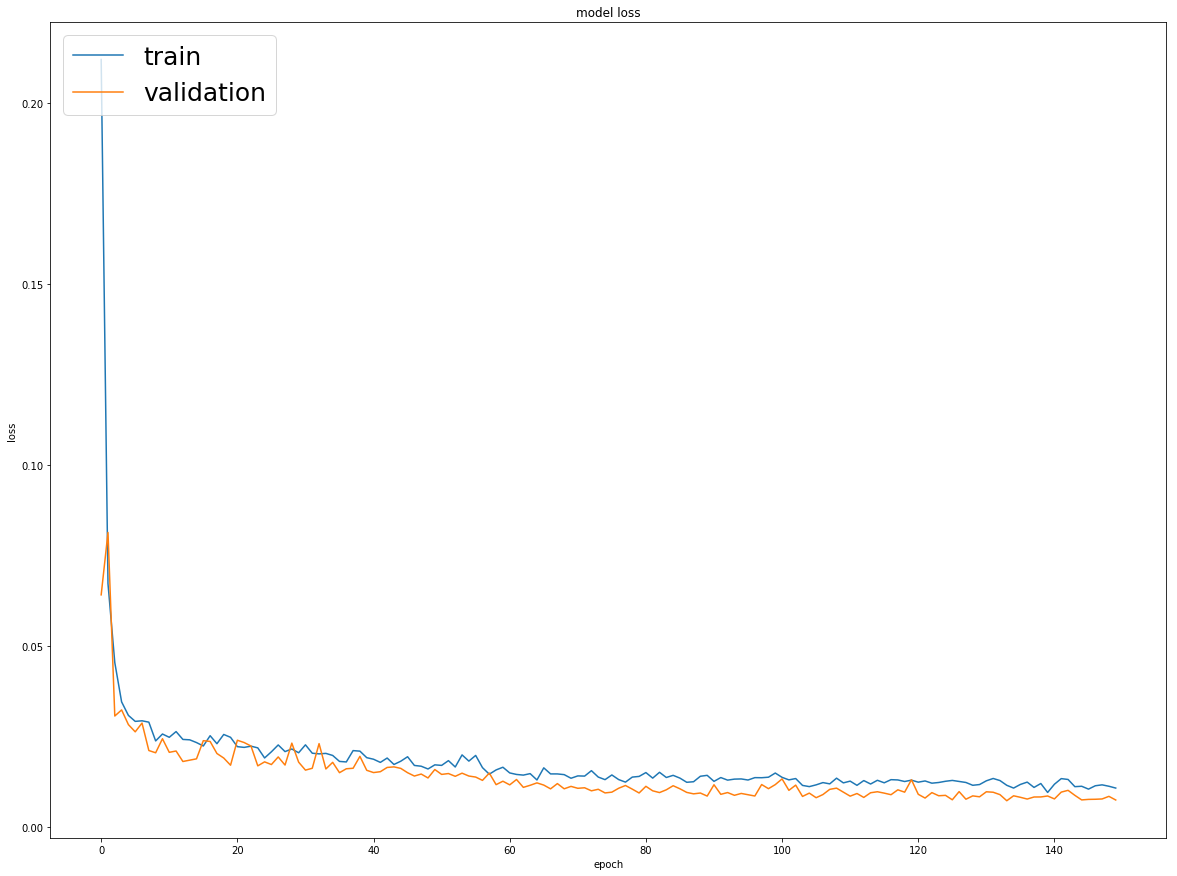

In [12]:
print(history.history.keys())
# "Loss"
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
matplotlib.rcParams.update({'font.size': 25})
plt.legend(['train', 'validation'], loc='upper left',prop={'size': 25})
plt.show()

## Predicting for Validation Dataset

In [13]:
ynew= model.predict(x_val.reshape(x_val.shape[0],30, 1))

## Plotting the Predicted Results

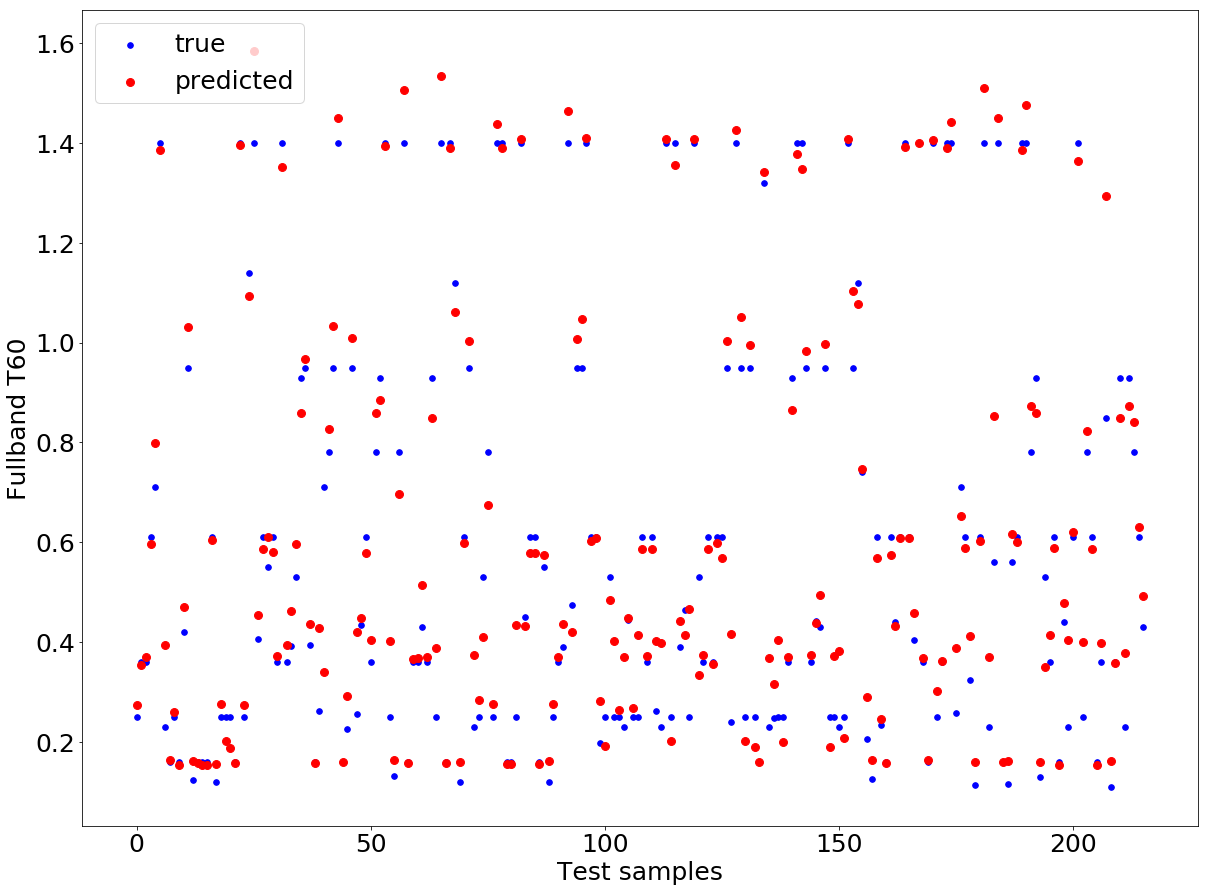

In [14]:
area = np.pi*10
area1 = np.pi*20
plt.figure(figsize=(20,15))
plt.scatter(range(np.shape(y_val)[0]), y_val,c='b',s=area,label='true')
plt.scatter(range(np.shape(y_val)[0]), ynew,c='r',s=area1,label='predicted')
plt.legend(loc='upper left',prop={'size': 25});
plt.xlabel('Test samples')
plt.ylabel('Fullband T60')
matplotlib.rcParams.update({'font.size': 25})
plt.savefig('DCT_full_Dataset')